In [2]:
# Install dependencies
!pip install torch torchvision opencv-python matplotlib seaborn albumentations transformers googletrans==3.1.0a0

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 61.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 34.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 38.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.0 MB/s eta 0:00:00
   ━━━━━━

In [ ]:
 Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Import libraries
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from albumentations import Compose, Rotate, HorizontalFlip, RandomBrightnessContrast, GaussNoise, Blur, Lambda
import albumentations.pytorch
from transformers import TrOCRProcessor, VisionEncoderDecoderModel, BertTokenizer, BertForMaskedLM, LineByLineTextDataset, DataCollatorForLanguageModeling, Trainer, TrainingArguments
from googletrans import Translator
from sklearn.model_selection import train_test_split
import shutil

In [4]:
# Set paths
base_path = '/content/drive/MyDrive/sinhala_inscription_project'
dataset_path = os.path.join(base_path, 'dataset')
output_path = os.path.join(base_path, 'output')
os.makedirs(dataset_path, exist_ok=True)
os.makedirs(output_path, exist_ok=True)

# Set matplotlib style
sns.set_theme()

In [5]:
# Organize dataset
images_path = os.path.join(dataset_path, 'images')
labels_path = os.path.join(dataset_path, 'labels')
train_img_path = os.path.join(dataset_path, 'train/images')
train_lbl_path = os.path.join(dataset_path, 'train/labels')
val_img_path = os.path.join(dataset_path, 'val/images')
val_lbl_path = os.path.join(dataset_path, 'val/labels')
os.makedirs(images_path, exist_ok=True)
os.makedirs(labels_path, exist_ok=True)
os.makedirs(train_img_path, exist_ok=True)
os.makedirs(train_lbl_path, exist_ok=True)
os.makedirs(val_img_path, exist_ok=True)
os.makedirs(val_lbl_path, exist_ok=True)


In [ ]:
#function to correct and clip bounding boxes
def fix_bboxes(bboxes, **kwargs):
    fixed_bboxes = []
    for bbox in bboxes:
        if len(bbox) >= 4:
            x, y, w, h = bbox[:4]  # Handle 4 or 5 elements
            # Compute min/max coordinates
            x_min = x - w/2
            y_min = y - h/2
            x_max = x + w/2
            y_max = y + h/2
            # Clip min/max to [0, 1]
            x_min = np.clip(x_min, 0.0, 1.0)
            y_min = np.clip(y_min, 0.0, 1.0)
            x_max = np.clip(x_max, 0.0, 1.0)
            y_max = np.clip(y_max, 0.0, 1.0)
            # Recompute center and size
            w_new = x_max - x_min
            h_new = y_max - y_min
            x_new = x_min + w_new / 2
            y_new = y_min + h_new / 2
            if w_new > 0 and h_new > 0:  # Ensure valid box
                fixed_bboxes.append([x_new, y_new, w_new, h_new])
        else:
            print(f"Warning: Skipping invalid bbox format: {bbox}")
    return fixed_bboxes
# Augmentation pipeline with single fix function
augmentation = Compose([
    Rotate(limit=15, p=0.5, border_mode=cv2.BORDER_CONSTANT),
    HorizontalFlip(p=0.5),
    RandomBrightnessContrast(p=0.3),
    GaussNoise(p=0.3),
    Blur(blur_limit=3, p=0.2),
    Lambda(bboxes=fix_bboxes, p=1.0)  # Apply fix at the end
], bbox_params={'format': 'yolo', 'label_fields': ['class_labels'], 'min_visibility': 0.0, 'check_each_transform': False})

def augment_and_save(image_path, label_path, output_img_dir, output_lbl_dir, num_augmentations=3):
    image = cv2.imread(image_path)
    if image is None:
        print(f"Failed to load image: {image_path}, skipping.")
        return
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    with open(label_path, 'r') as f:
        lines = f.readlines()
    bboxes = []
    class_labels = []
    for line in lines:
        try:
            cls, x, y, w, h = map(float, line.strip().split())
            x, y, w, h = np.clip(x, 0, 1), np.clip(y, 0, 1), np.clip(w, 0, 1), np.clip(h, 0, 1)
            if w > 0 and h > 0:
                bboxes.append([x, y, w, h])
                class_labels.append(int(cls))
        except ValueError:
            print(f"Invalid label format in {label_path}: {line.strip()}, skipping line.")
            continue

    if not bboxes:
        print(f"No valid bounding boxes in {label_path}, skipping augmentation.")
        return
    # Convert bboxes to NumPy array for augmentation
    bboxes = np.array(bboxes)
    for i in range(num_augmentations):
        augmented = augmentation(image=image, bboxes=bboxes, class_labels=class_labels)
        aug_img = augmented['image']
        aug_bboxes = augmented['bboxes']
        aug_labels = augmented['class_labels']

        # Additional safety check (should be redundant with Lambda, but kept for robustness)
        valid_bboxes = []
        valid_labels = []
        for bbox, cls in zip(aug_bboxes, aug_labels):
            if len(bbox) >= 4:
                x, y, w, h = bbox[:4]
                x_min = x - w/2
                y_min = y - h/2
                x_max = x + w/2
                y_max = y + h/2
                # Clip again to be extra sure
                x_min = np.clip(x_min, 0.0, 1.0)
                y_min = np.clip(y_min, 0.0, 1.0)
                x_max = np.clip(x_max, 0.0, 1.0)
                y_max = np.clip(y_max, 0.0, 1.0)
                w_new = x_max - x_min
                h_new = y_max - y_min
                x_new = x_min + w_new / 2
                y_new = y_min + h_new / 2
                if w_new > 0 and h_new > 0:
                    valid_bboxes.append([x_new, y_new, w_new, h_new])
                    valid_labels.append(cls)
            else:
                print(f"Post-augmentation invalid bbox format: {bbox}, skipping.")

        if not valid_bboxes:
            print(f"No valid boxes after augmentation {i} for {image_path}, skipping.")
            continue

        base_name = os.path.splitext(os.path.basename(image_path))[0]
        aug_img_path = os.path.join(output_img_dir, f"{base_name}_aug_{i}.jpg")
        cv2.imwrite(aug_img_path, cv2.cvtColor(aug_img, cv2.COLOR_RGB2BGR))

        aug_lbl_path = os.path.join(output_lbl_dir, f"{base_name}_aug_{i}.txt")
        with open(aug_lbl_path, 'w') as f:
            for bbox, cls in zip(valid_bboxes, valid_labels):
                x, y, w, h = bbox
                f.write(f"{cls} {x} {y} {w} {h}\n")

In [ ]:
# EAST Dataset
class EASTDataset(Dataset):
    def __init__(self, img_dir, lbl_dir, input_size=512, output_size=128):
        self.img_dir = img_dir
        self.lbl_dir = lbl_dir
        self.input_size = input_size
        self.output_size = output_size
        self.images = [f for f in os.listdir(img_dir) if f.endswith(('.jpg', '.png'))]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.images[idx])
        lbl_path = os.path.join(self.lbl_dir, self.images[idx].replace('.jpg', '.txt').replace('.png', '.txt'))

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        h, w = img.shape[:2]

        boxes = []
        if os.path.exists(lbl_path):
            with open(lbl_path, 'r') as f:
                for line in f.readlines():
                    _, x, y, w_norm, h_norm = map(float, line.strip().split())
                    x1 = int((x - w_norm/2) * w)
                    y1 = int((y - h_norm/2) * h)
                    x2 = int((x + w_norm/2) * w)
                    y2 = int((y + h_norm/2) * h)
                    boxes.append([x1, y1, x2, y2])

        img_resized = cv2.resize(img, (self.input_size, self.input_size))
        img_tensor = torch.from_numpy(img_resized.transpose(2, 0, 1)).float() / 255.0

        score_map = np.zeros((self.output_size, self.output_size), dtype=np.float32)
        geo_map = np.zeros((self.output_size, self.output_size, 5), dtype=np.float32)
        scale = self.input_size / self.output_size

        for box in boxes:
            x1, y1, x2, y2 = [int(coord / scale) for coord in box]
            score_map[y1:y2, x1:x2] = 1
            geo_map[y1:y2, x1:x2, 0] = y1 * scale - box[1]
            geo_map[y1:y2, x1:x2, 1] = box[2] - x2 * scale
            geo_map[y1:y2, x1:x2, 2] = box[3] - y2 * scale
            geo_map[y1:y2, x1:x2, 3] = x1 * scale - box[0]
            geo_map[y1:y2, x1:x2, 4] = 0

        return img_tensor, torch.from_numpy(score_map), torch.from_numpy(geo_map)

train_dataset = EASTDataset(train_img_path, train_lbl_path)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_dataset = EASTDataset(val_img_path, val_lbl_path)
val_loader = DataLoader(val_dataset, batch_size=4)

In [ ]:
class EAST(nn.Module):
    def __init__(self):
        super(EAST, self).__init__()

        # Feature extractor
        self.backbone = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 16, 3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 16, 3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 1/2

            # Block 2
            nn.Conv2d(16, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 1/4

            # Block 3
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)   # 1/8
        )

        # Feature merging
        self.merge = nn.Sequential(
            nn.Conv2d(64, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 16, 3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU()
        )

        # Output heads
        self.score = nn.Conv2d(16, 1, 1)  # Text/non-text classification
        self.geo = nn.Conv2d(16, 4, 1)    # Geometry prediction 

    def forward(self, x):
        x = self.backbone(x)
        x = nn.functional.interpolate(x, scale_factor=2, mode='bilinear', align_corners=False)
        x = self.merge(x)
        score = torch.sigmoid(self.score(x))
        geo = self.geo(x)
        return score, geo

def east_loss(score_pred, score_gt, geo_pred, geo_gt):
    # Classification loss
    score_loss = nn.functional.binary_cross_entropy(score_pred.squeeze(1), score_gt)

    # Geometry loss (only for positive samples)
    mask = (score_gt > 0.5).unsqueeze(-1)
    geo_pred = geo_pred.permute(0, 2, 3, 1)
    geo_diff = torch.abs(geo_pred - geo_gt) * mask
    geo_loss = geo_diff.sum() / (mask.sum() + 1e-6)

    return score_loss + geo_loss


In [ ]:
from tqdm import tqdm
# Define EAST model
class EAST(nn.Module):
    def __init__(self):
        super(EAST, self).__init__()
        self.backbone = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 256x256
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 128x128
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2, 2)  # 64x64
        )
        self.merge = nn.Sequential(
            nn.Conv2d(128, 64, 3, padding=1), nn.ReLU(),
            nn.Conv2d(64, 32, 3, padding=1), nn.ReLU()
        )
        self.score = nn.Conv2d(32, 1, 1)
        self.geo = nn.Conv2d(32, 5, 1)

    def forward(self, x):
        x = self.backbone(x)
        x = nn.functional.interpolate(x, size=(128, 128), mode='bilinear', align_corners=False)
        x = self.merge(x)
        score = torch.sigmoid(self.score(x))  # [B, 1, 128, 128]
        geo = self.geo(x)                     # [B, 5, 128, 128]
        return score, geo

# Updated EAST Loss
def east_loss(score_pred, score_gt, geo_pred, geo_gt):
    score_loss = nn.BCELoss()(score_pred, score_gt)
    mask = score_gt > 0
    geo_pred = geo_pred.permute(0, 2, 3, 1)  # [B, 5, 128, 128] -> [B, 128, 128, 5]
    mask = mask.unsqueeze(-1).expand_as(geo_pred)
    if mask.sum() > 0:
        geo_loss = torch.abs(geo_pred - geo_gt)[mask].mean()
    else:
        geo_loss = torch.tensor(0.0, device=score_pred.device)
    return score_loss + geo_loss

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize model and training
model = EAST().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)  # Lowered LR to reduce overfitting
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)  # Softer decay

# DataLoader with optimized settings
train_subset = torch.utils.data.Subset(train_dataset, range(50))  # Increased to 50 samples
train_loader = DataLoader(train_subset, batch_size=2, shuffle=True, num_workers=0)  # No workers for speed
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False, num_workers=0)

epochs = 30  #epochs
train_losses = []
val_losses = []

for epoch in range(epochs):
    model.train()
    train_loss = 0
    for img, score_gt, geo_gt in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        img, score_gt, geo_gt = img.to(device), score_gt.to(device), geo_gt.to(device)
        optimizer.zero_grad()
        score_pred, geo_pred = model(img)
        score_pred = score_pred.squeeze(1)
        loss = east_loss(score_pred, score_gt, geo_pred, geo_gt)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
        optimizer.step()
        train_loss += loss.item()
    train_losses.append(train_loss / len(train_loader))
  # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for img, score_gt, geo_gt in val_loader:
            img, score_gt, geo_gt = img.to(device), score_gt.to(device), geo_gt.to(device)
            score_pred, geo_pred = model(img)
            score_pred = score_pred.squeeze(1)
            loss = east_loss(score_pred, score_gt, geo_pred, geo_gt)
            val_loss += loss.item()
    val_losses.append(val_loss / len(val_loader))

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")
    scheduler.step()
# Save the model
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_losses': train_losses,
    'val_losses': val_losses
}, 'east_model.pth')
print("Model saved as 'east_model.pth'")

Epoch 1/30: 100%|██████████| 25/25 [02:27<00:00,  5.90s/it]


Epoch 1/30, Train Loss: 1.2896, Val Loss: 0.7848


Epoch 2/30: 100%|██████████| 25/25 [01:53<00:00,  4.55s/it]


Epoch 2/30, Train Loss: 1.2231, Val Loss: 0.8213


Epoch 3/30: 100%|██████████| 25/25 [01:53<00:00,  4.53s/it]


Epoch 3/30, Train Loss: 1.2209, Val Loss: 0.9232


Epoch 4/30: 100%|██████████| 25/25 [02:03<00:00,  4.94s/it]


Epoch 4/30, Train Loss: 1.1760, Val Loss: 1.3054


Epoch 5/30: 100%|██████████| 25/25 [01:55<00:00,  4.62s/it]


Epoch 5/30, Train Loss: 1.1363, Val Loss: 1.1662


Epoch 6/30: 100%|██████████| 25/25 [01:55<00:00,  4.62s/it]


Epoch 6/30, Train Loss: 1.0905, Val Loss: 1.1176


Epoch 7/30: 100%|██████████| 25/25 [02:00<00:00,  4.81s/it]


Epoch 7/30, Train Loss: 1.0996, Val Loss: 1.1168


Epoch 8/30: 100%|██████████| 25/25 [02:03<00:00,  4.94s/it]


Epoch 8/30, Train Loss: 1.0833, Val Loss: 1.2130


Epoch 9/30: 100%|██████████| 25/25 [01:53<00:00,  4.56s/it]


Epoch 9/30, Train Loss: 1.0854, Val Loss: 1.3415


Epoch 10/30: 100%|██████████| 25/25 [01:55<00:00,  4.63s/it]


Epoch 10/30, Train Loss: 1.0787, Val Loss: 1.1652


Epoch 11/30: 100%|██████████| 25/25 [01:56<00:00,  4.64s/it]


Epoch 11/30, Train Loss: 1.0662, Val Loss: 1.1404


Epoch 12/30: 100%|██████████| 25/25 [01:55<00:00,  4.63s/it]


Epoch 12/30, Train Loss: 1.0759, Val Loss: 1.1313


Epoch 13/30: 100%|██████████| 25/25 [02:00<00:00,  4.83s/it]


Epoch 13/30, Train Loss: 1.0608, Val Loss: 1.1513


Epoch 14/30: 100%|██████████| 25/25 [01:56<00:00,  4.66s/it]


Epoch 14/30, Train Loss: 1.0675, Val Loss: 1.1290


Epoch 15/30: 100%|██████████| 25/25 [01:54<00:00,  4.58s/it]


Epoch 15/30, Train Loss: 1.0707, Val Loss: 1.1528


Epoch 16/30: 100%|██████████| 25/25 [01:56<00:00,  4.67s/it]


Epoch 16/30, Train Loss: 1.0562, Val Loss: 1.1476


Epoch 17/30: 100%|██████████| 25/25 [01:54<00:00,  4.60s/it]


Epoch 17/30, Train Loss: 1.0466, Val Loss: 1.1192


Epoch 18/30: 100%|██████████| 25/25 [02:04<00:00,  4.98s/it]


Epoch 18/30, Train Loss: 1.0664, Val Loss: 1.1378


Epoch 19/30: 100%|██████████| 25/25 [01:56<00:00,  4.67s/it]


Epoch 19/30, Train Loss: 1.0637, Val Loss: 1.1212


Epoch 20/30: 100%|██████████| 25/25 [01:53<00:00,  4.54s/it]


Epoch 20/30, Train Loss: 1.0700, Val Loss: 1.1008


Epoch 21/30: 100%|██████████| 25/25 [01:54<00:00,  4.56s/it]


Epoch 21/30, Train Loss: 1.0591, Val Loss: 1.1123


Epoch 22/30: 100%|██████████| 25/25 [02:04<00:00,  4.97s/it]


Epoch 22/30, Train Loss: 1.0453, Val Loss: 1.1132


Epoch 23/30: 100%|██████████| 25/25 [01:55<00:00,  4.61s/it]


Epoch 23/30, Train Loss: 1.0630, Val Loss: 1.1128


Epoch 24/30: 100%|██████████| 25/25 [01:54<00:00,  4.58s/it]


Epoch 24/30, Train Loss: 1.0554, Val Loss: 1.1193


Epoch 25/30: 100%|██████████| 25/25 [01:54<00:00,  4.58s/it]


Epoch 25/30, Train Loss: 1.0547, Val Loss: 1.1179


Epoch 26/30: 100%|██████████| 25/25 [01:55<00:00,  4.63s/it]


Epoch 26/30, Train Loss: 1.0562, Val Loss: 1.1139


Epoch 27/30: 100%|██████████| 25/25 [01:55<00:00,  4.60s/it]


Epoch 27/30, Train Loss: 1.0593, Val Loss: 1.1180


Epoch 28/30: 100%|██████████| 25/25 [01:55<00:00,  4.64s/it]


Epoch 28/30, Train Loss: 1.0529, Val Loss: 1.1182


Epoch 29/30: 100%|██████████| 25/25 [01:55<00:00,  4.63s/it]


Epoch 29/30, Train Loss: 1.0491, Val Loss: 1.1183


Epoch 30/30: 100%|██████████| 25/25 [01:54<00:00,  4.60s/it]


Epoch 30/30, Train Loss: 1.0626, Val Loss: 1.1226
Model saved as 'train_model.pth'


In [10]:
import matplotlib.pyplot as plt
import numpy as np
# Function to smooth curves
def smooth_curve(points, factor=0.8):
    smoothed = []
    for point in points:
        if smoothed:
            previous = smoothed[-1]
            smoothed.append(previous * factor + point * (1 - factor))
        else:
            smoothed.append(point)
    return smoothed

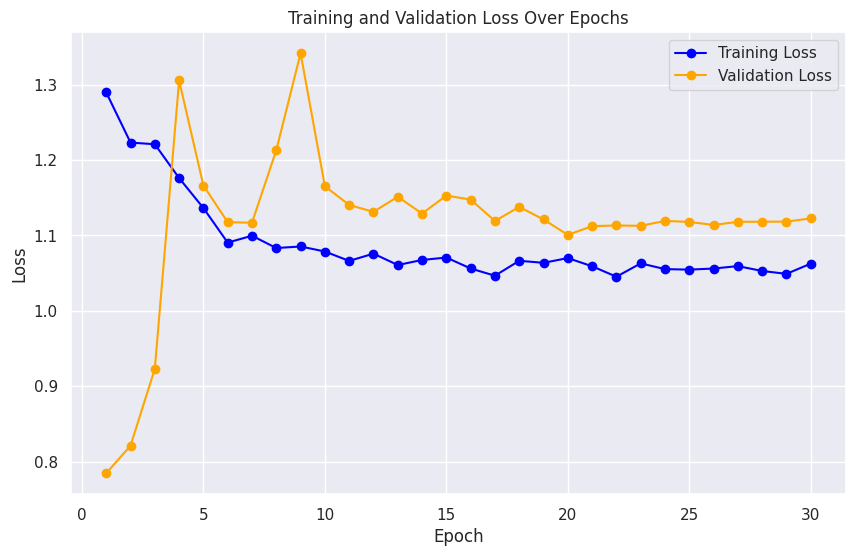

In [11]:
# Plot 1: Training and Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss', color='blue', marker='o')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss', color='orange', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

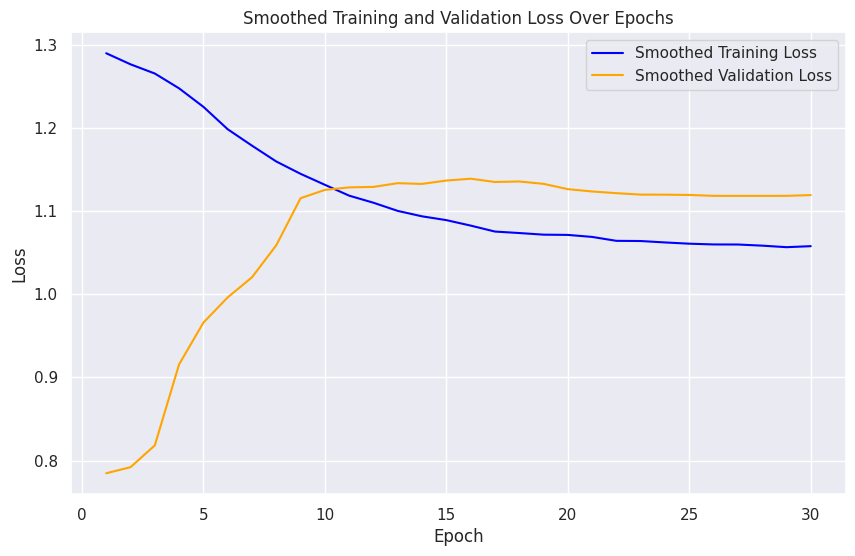

In [12]:
# Plot 2: Smoothed Loss Curves (optional, for better readability)
plt.figure(figsize=(10, 6))
smoothed_train = smooth_curve(train_losses)
smoothed_val = smooth_curve(val_losses)
plt.plot(range(1, len(smoothed_train) + 1), smoothed_train, label='Smoothed Training Loss', color='blue')
plt.plot(range(1, len(smoothed_val) + 1), smoothed_val, label='Smoothed Validation Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Smoothed Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

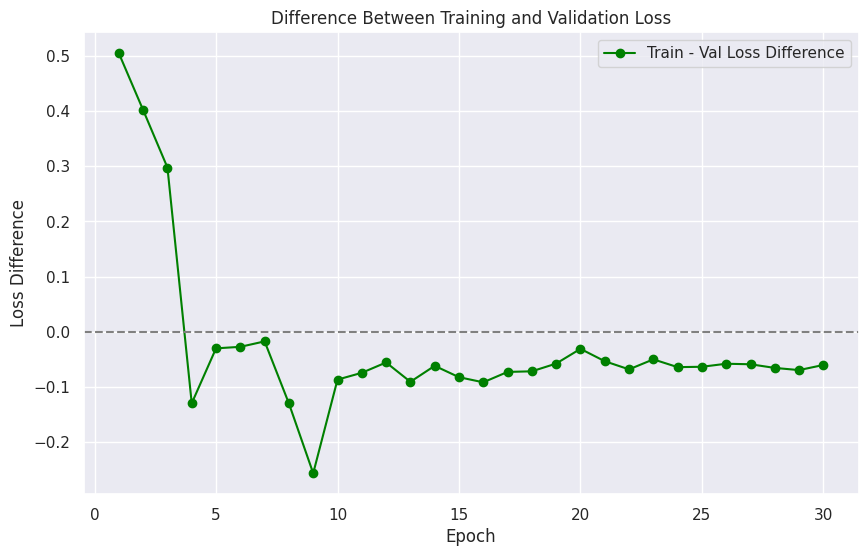

In [13]:
# Plot 3: Loss Difference (optional, to analyze overfitting)
plt.figure(figsize=(10, 6))
loss_diff = np.array(train_losses) - np.array(val_losses)
plt.plot(range(1, len(loss_diff) + 1), loss_diff, label='Train - Val Loss Difference', color='green', marker='o')
plt.axhline(0, color='gray', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss Difference')
plt.title('Difference Between Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()